In [1]:
import os

# Replace with your local folder path
path = "archive (4)"

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


archive (4)\BNBUSDT.csv
archive (4)\BNBUSDT_norm.csv
archive (4)\BTCUSDT.csv
archive (4)\BTCUSDT_norm.csv
archive (4)\ETHUSDT.csv
archive (4)\ETHUSDT_norm.csv
archive (4)\XRPUSDT.csv
archive (4)\XRPUSDT_norm.csv


In [13]:
import os
import pandas as pd

# Path to your folder
path = "archive (4)"

# Loop through files and print columns
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        file_path = os.path.join(path, filename)
        df = pd.read_csv(file_path, nrows=5)  # only read first 5 rows for speed
        print(f"\n{filename} -> Columns: {list(df.columns)}")



BNBUSDT.csv -> Columns: ['Unnamed: 0', 'Open', 'Close', 'Low', 'High', 'Volume', 'sma7', 'sma25', 'sma99', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'psar', 'RSI']

BNBUSDT_norm.csv -> Columns: ['Unnamed: 0', 'Open', 'Close', 'Low', 'High', 'Volume', 'sma7', 'sma25', 'sma99', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'psar', 'RSI']

BTCUSDT.csv -> Columns: ['Unnamed: 0', 'Open', 'Close', 'Low', 'High', 'Volume', 'sma7', 'sma25', 'sma99', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'psar', 'RSI']

BTCUSDT_norm.csv -> Columns: ['Unnamed: 0', 'Open', 'Close', 'Low', 'High', 'Volume', 'sma7', 'sma25', 'sma99', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'psar', 'RSI']

ETHUSDT.csv -> Columns: ['Unnamed: 0', 'Open', 'Close', 'Low', 'High', 'Volume', 'sma7', 'sma25', 'sma99', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'psar', 'RSI']

ETHUSDT_norm.csv -> Columns: ['Unnamed: 0', 'Open', 'Close', 'Low', 'High', 'Volume', 'sma7', 'sma25', 'sma99', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'psar', 'RSI']

XRPUSDT.csv -> Columns: ['Unnamed: 0', 'Open', 'Close', 'Low', 'Hi

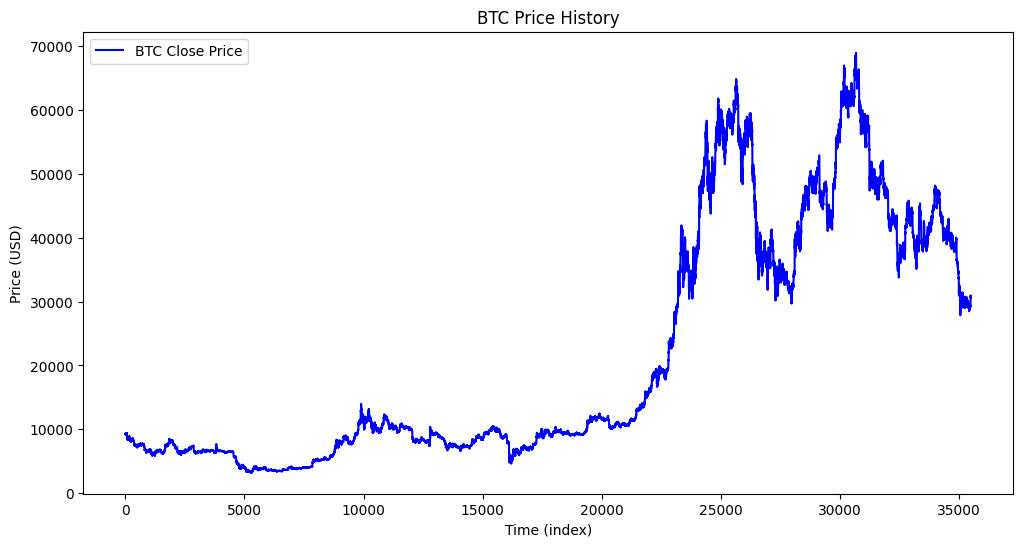

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

btc = pd.read_csv("archive (4)/BTCUSDT.csv")

plt.figure(figsize=(12,6))
plt.plot(btc["Close"], label="BTC Close Price", color="blue")
plt.title("BTC Price History")
plt.xlabel("Time (index)")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


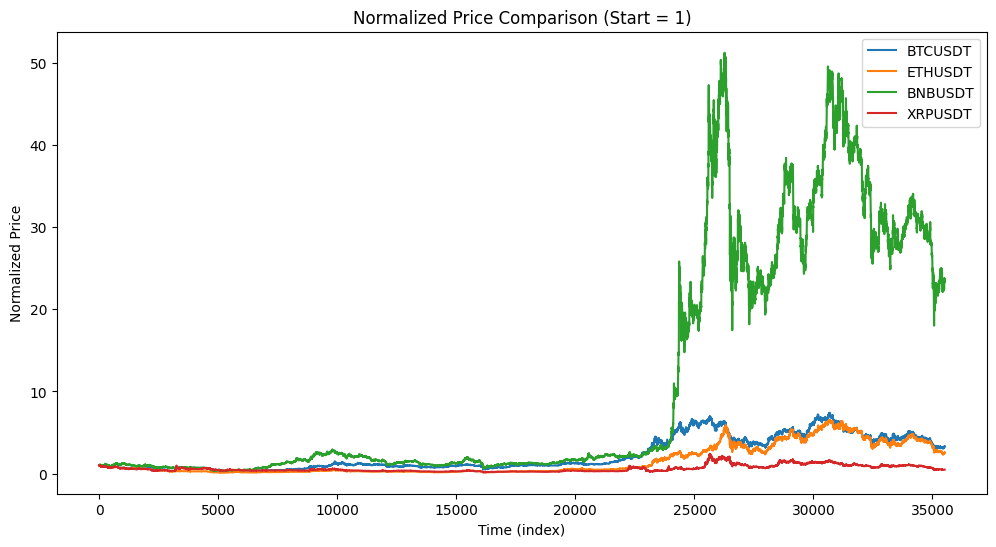

In [15]:
import matplotlib.pyplot as plt

assets = ["BTCUSDT.csv", "ETHUSDT.csv", "BNBUSDT.csv", "XRPUSDT.csv"]
plt.figure(figsize=(12,6))

for asset in assets:
    df = pd.read_csv(f"archive (4)/{asset}")
    plt.plot(df["Close"] / df["Close"].iloc[0], label=asset.replace(".csv",""))

plt.title("Normalized Price Comparison (Start = 1)")
plt.xlabel("Time (index)")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()


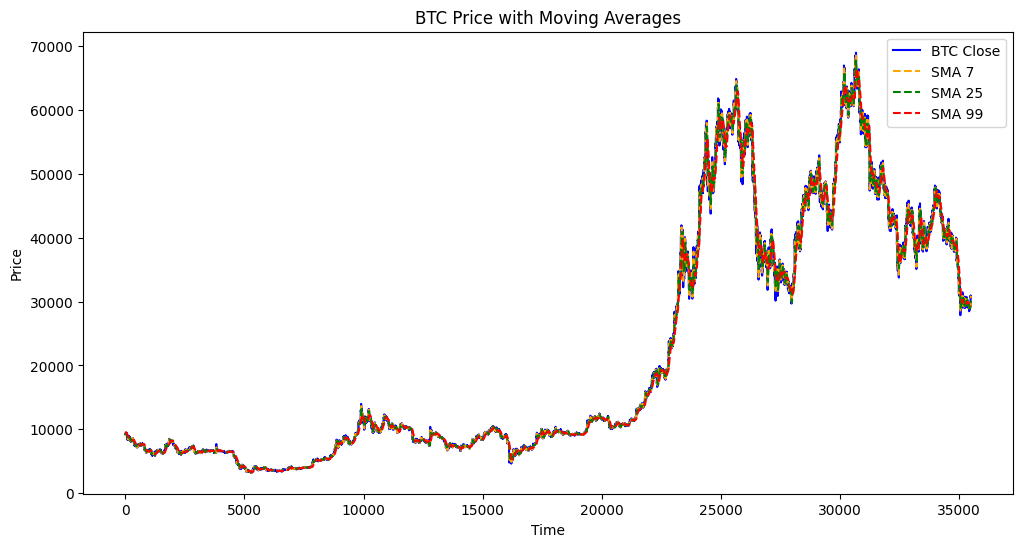

In [16]:
plt.figure(figsize=(12,6))
plt.plot(btc["Close"], label="BTC Close", color="blue")
plt.plot(btc["sma7"], label="SMA 7", linestyle="--", color="orange")
plt.plot(btc["sma25"], label="SMA 25", linestyle="--", color="green")
plt.plot(btc["sma99"], label="SMA 99", linestyle="--", color="red")

plt.title("BTC Price with Moving Averages")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


Environment

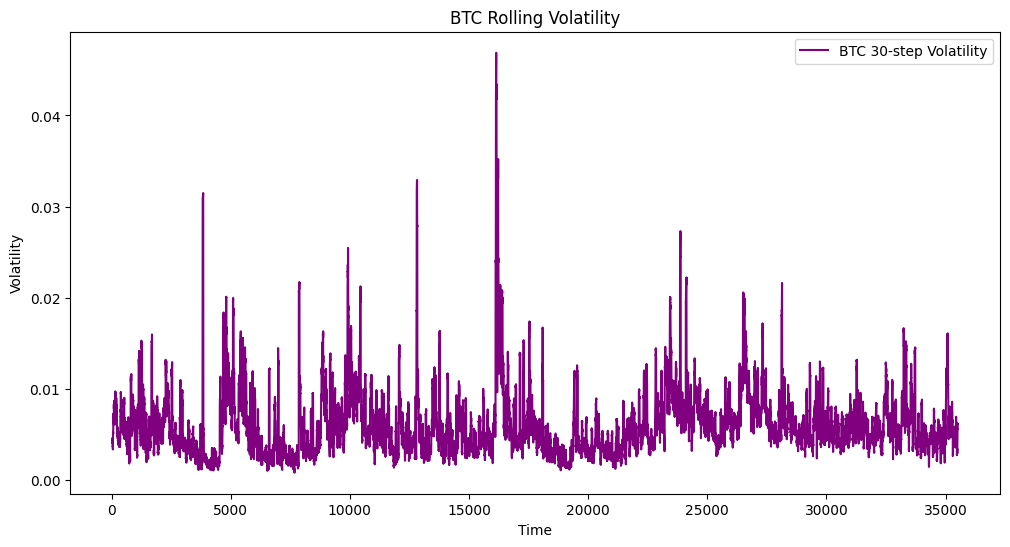

In [17]:
btc["Returns"] = btc["Close"].pct_change()
btc["Volatility"] = btc["Returns"].rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(btc["Volatility"], color="purple", label="BTC 30-step Volatility")
plt.title("BTC Rolling Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()


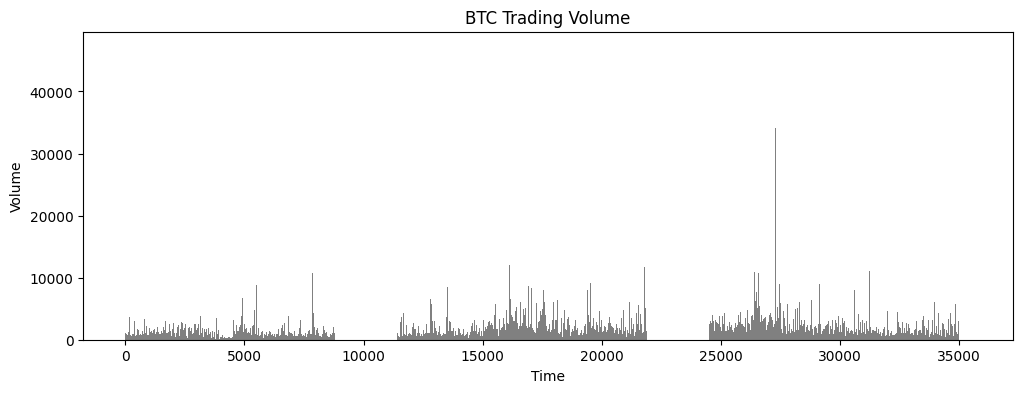

In [18]:
plt.figure(figsize=(12,4))
plt.bar(range(len(btc["Volume"])), btc["Volume"], color="grey")
plt.title("BTC Trading Volume")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.show()


In [ ]:
import numpy as np
import random
from collections import deque

class SimpleTradingEnv:
    """Simplified trading environment"""

    def __init__(self, df, initial_balance=1000, lookback_window_size=50):
        self.df = df                          # price dataset (e.g., shape: [time, assets])
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.balance = self.initial_balance   # start with all cash
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.current_step = self.lookback_window_size
        self.quants = np.zeros(self.df.shape[1])  # no assets at start

        # store past steps of prices (observation window)
        self.history = deque(maxlen=self.lookback_window_size)
        for i in range(self.lookback_window_size):
            self.history.append(self.df[self.current_step - i - 1])

        return np.array(self.history)

    def step(self, action, transaction_cost=0.001):
        """
        Take one step in the environment.
        action = portfolio weights (e.g., [0.5, 0.5] for 2 assets)
        """
        prices_old = self.df[self.current_step - 1]
        self.current_step += 1
        prices_new = self.df[self.current_step]

        # asset returns
        returns = prices_new / prices_old - 1.0

        # portfolio return (dot product of weights and returns)
        portfolio_return = np.dot(action, returns)

        # update net worth
        self.prev_net_worth = self.net_worth
        self.net_worth *= (1 + portfolio_return)

        # transaction cost penalty
        cost = transaction_cost * self.net_worth * np.sum(np.abs(action))
        self.net_worth -= cost

        # reward: log change in net worth
        reward = np.log(self.net_worth / self.prev_net_worth)

        # done if bankrupt
        done = self.net_worth <= self.initial_balance / 2

        # update history for next state
        self.history.append(prices_new)
        obs = np.array(self.history)

        return obs, reward, done, self.net_worth


    def render(self):
        print(f"Step: {self.current_step}, Net Worth: {self.net_worth:.2f}")


Agent

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

class SimpleAgent:
    """Simplified Actor-Critic trading agent"""

    def __init__(self, state_size, action_size, lr=0.001):
        self.state_size = state_size    # shape of input (lookback_window, features)
        self.action_size = action_size  # number of assets
        self.lr = lr

        # Build Actor (policy network → outputs portfolio weights)
        self.actor = models.Sequential([
            layers.Input(shape=self.state_size),
            layers.Flatten(),
            layers.Dense(64, activation="relu"),
            layers.Dense(self.action_size, activation="softmax")  # portfolio weights
        ])
        self.actor.compile(optimizer=optimizers.Adam(learning_rate=self.lr),
                           loss="categorical_crossentropy")

        # Build Critic (value network → predicts expected return)
        self.critic = models.Sequential([
            layers.Input(shape=self.state_size),
            layers.Flatten(),
            layers.Dense(64, activation="relu"),
            layers.Dense(1, activation="linear")  # value estimate
        ])
        self.critic.compile(optimizer=optimizers.Adam(learning_rate=self.lr),
                            loss="mse")

    def act(self, state):
        """Choose an action (portfolio weights) given current state"""
        state = np.expand_dims(state, axis=0)  # add batch dimension
        action_probs = self.actor.predict(state, verbose=0)[0]
        return action_probs

    def train(self, state, action_probs, reward, next_state, done, gamma=0.99):
        """One-step Actor-Critic update"""
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)

        # Critic estimates
        value = self.critic.predict(state, verbose=0)[0]
        next_value = self.critic.predict(next_state, verbose=0)[0]

        # Compute target for critic
        target = reward + (0 if done else gamma * next_value)
        advantage = target - value

        # Train critic
        self.critic.train_on_batch(state, np.array([target]))

        # Train actor (policy gradient with advantage)
        self.actor.train_on_batch(state, np.expand_dims(action_probs, axis=0),
                                  sample_weight=np.array([advantage]))



In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, backend as K

class SimpleActor:
    """Actor network: chooses actions (portfolio weights)"""
    def __init__(self, input_shape, action_space, lr=0.001):
        self.action_space = action_space

        inputs = layers.Input(shape=input_shape)
        x = layers.Flatten()(inputs)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(32, activation="relu")(x)
        outputs = layers.Dense(action_space, activation="softmax")(x)

        self.model = models.Model(inputs, outputs)
        self.model.compile(optimizer=optimizers.Adam(lr), loss="categorical_crossentropy")

    def predict(self, state):
        return self.model.predict(np.expand_dims(state, axis=0), verbose=0)[0]

    def train(self, state, action, advantage):
        state = np.expand_dims(state, axis=0)
        action = np.expand_dims(action, axis=0)
        self.model.train_on_batch(state, action, sample_weight=np.array([advantage]))


class SimpleCritic:
    """Critic network: evaluates state value"""
    def __init__(self, input_shape, lr=0.001):
        inputs = layers.Input(shape=input_shape)
        x = layers.Flatten()(inputs)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(32, activation="relu")(x)
        outputs = layers.Dense(1, activation="linear")(x)

        self.model = models.Model(inputs, outputs)
        self.model.compile(optimizer=optimizers.Adam(lr), loss="mse")

    def predict(self, state):
        return self.model.predict(np.expand_dims(state, axis=0), verbose=0)[0]

    def train(self, state, target):
        state = np.expand_dims(state, axis=0)
        self.model.train_on_batch(state, np.array([target]))
